In [155]:
# Import and setup
%matplotlib inline
# import sys
# !conda install --yes --prefix {sys.prefix} seaborn
import seaborn as sns
import numpy as np, pandas as pd

# pd.set_option('display.max_rows', 500)

In [156]:
# Use CPI for adjustments to conston 2004 dollars, from https://www.bls.gov/data/inflation_calculator.htm (July of each year)
inflation = pd.DataFrame({'Year' : np.arange(2004,2018),'stat':[1.00, 0.97, 0.93, 0.91, 0.86, 0.88, 0.87, 0.84, 0.83, 0.81, 0.79, 0.79, 0.79, 0.77]})
inflation['Year'] = inflation['Year'].apply(str)
inflation.set_index('Year', inplace=True)

In [252]:
# Import service data and operating expenses from 
# https://www.transit.dot.gov/ntd/data-product/ts21-service-data-and-operating-expenses-time-series-mode-2
tables = ['OpExp Total', 'VRM', 'VRH', 'UPT', 'PMT'] # Sheets in Excel workbook
svcdf = []

for table in tables:
    rawdf = pd.read_excel(
        'NTD/TS2.1TimeSeriesOpExpSvcModeTOS_2.xlsx', 
        table,
        converters={
            'Legacy NTD ID': str
        }
    )        
    
    svcdf.append(rawdf[
        (rawdf['Mode'] == 'MB') &  #MB = municipal bus mode
        (rawdf['Reporter Type'] == 'Full Reporter') &
        (rawdf['UZA Population'] > 250000)
    ])
    
    print('Done importing ' + table)
    

Done importing OpExp Total
Done importing VRM
Done importing VRH
Done importing UPT
Done importing PMT


In [253]:
# Process service data and operating expenses
dropColumns = ['Last Report Year', 'NTD ID', 'Census Year',  'UZA Area SQ Miles', 'UZA Population']
sumByColumns = ['UZA', 'UZA Name']
indexColumns = ['UZA', 'UZA Name', 'Year']

def dropColsAndSumBy(tableName, dropCols, sumByCols):
    'Drop unneeded columns, then group by desired columns and sum values'
    return svcdf[tables.index(tableName)].fillna(0).drop(dropColumns, axis=1).groupby(sumByCols).sum()

def meltYears(df, start, end, meltCols, indexCols):
    'Extract selected rows, then melt, sort, and reset index'
    return df[df.fillna(0).ne(0).all(axis=1)] \
        .loc[:,start:end].reset_index() \
        .melt(meltCols, var_name='Year', value_name='stat') \
        .sort_values(indexCols) \
        .set_index(indexCols)

# Vehicle Revenue Miles
vrm = dropColsAndSumBy('VRM', dropColumns, sumByColumns)
vrm = meltYears(vrm, '2004', '2017', sumByColumns, indexColumns)
    
# Vehicle Revenue Hours
vrh = dropColsAndSumBy('VRH', dropColumns, sumByColumns)
vrh = meltYears(vrh, '2004', '2017', sumByColumns, indexColumns)

# Passenger Miles Traveled
pmt = dropColsAndSumBy('PMT', dropColumns, sumByColumns)
pmt = meltYears(pmt, '2004', '2017', sumByColumns, indexColumns)

# Unlinked Passenger Boardings
upt = dropColsAndSumBy('UPT', dropColumns, sumByColumns)
upt = meltYears(upt, '2004', '2017', sumByColumns, indexColumns)

# Operating Expenses
opex = dropColsAndSumBy('OpExp Total', dropColumns, sumByColumns)
opex = meltYears(opex, '2004', '2017', sumByColumns, indexColumns)
opex = opex * inflation

C:\Users\Anson\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2657: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)


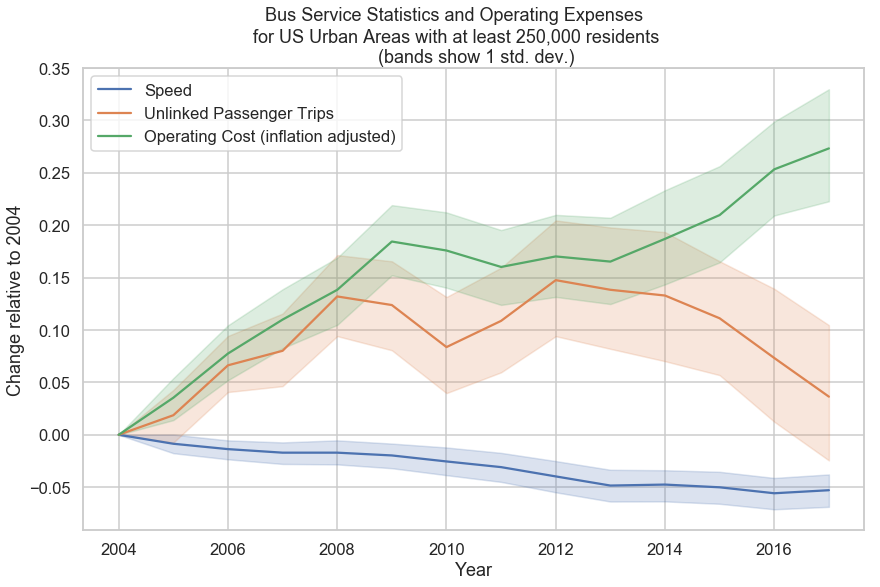

In [256]:
# Calculate and chart measures derived from service data and operating expenses
indexColumns = ['UZA Name', 'Year']

def relativeToYear(df, year, indexCols):
    'Convert to change relative to a given year'
    rel = df / df.xs(year, level=2) - 1
    rel = rel.reset_index(level = indexCols)
    return rel
    
def cleanForCharting(df):
    'Labeling fixes'
    df['Year'] = df['Year'].apply(int)
    df['UZA Name'] = df['UZA Name'].apply(lambda x: str.split(str.split(x, '-')[0],',')[0])
    return df

speed = vrm / vrh
speed = relativeToYear(speed, '2004', indexColumns)
speed = cleanForCharting(speed)

opex_vrm = opex / vrm
opex_vrm = relativeToYear(opex_vrm, '2004', indexColumns)
opex_vrm = cleanForCharting(opex_vrm)

opex_pmt = opex / pmt
opex_pmt = relativeToYear(opex_pmt, '2004', indexColumns)
opex_pmt = cleanForCharting(opex_pmt)

opex_rel = relativeToYear(opex, '2004', indexColumns)
opex_rel = cleanForCharting(opex_rel)

vrm_rel = relativeToYear(vrm, '2004', indexColumns)
vrm_rel = cleanForCharting(vrm_rel)

vrh_rel = relativeToYear(vrh, '2004', indexColumns)
vrh_rel = cleanForCharting(vrh_rel)

upt_rel = relativeToYear(upt, '2004', indexColumns)
upt_rel = cleanForCharting(upt_rel)

# This chart shows mean/variance across urban areas, not weighted by population or service
# Plot with Seaborn
sns.set(rc={'figure.figsize':(14,8.5)})
sns.set_style("whitegrid")
sns.set_context('talk')

# ax = sns.lineplot(x='Year', y='stat', label='Vehicle Revenue Hours', data=vrh_rel)
# ax = sns.lineplot(x='Year', y='stat', label='Vehicle Revenue Miles', data=vrm_rel)
ax = sns.lineplot(x='Year', y='stat', label='Speed', data=speed)
ax = sns.lineplot(x='Year', y='stat',  label='Unlinked Passenger Trips',data=upt_rel)
ax = sns.lineplot(x='Year', y='stat', label='Operating Cost (inflation adjusted)', data=opex_rel)
ax.set(ylabel='Change relative to 2004', title='Bus Service Statistics and Operating Expenses \
       \n for US Urban Areas with at least 250,000 residents \
       \n (bands show 1 std. dev.)')

ax.legend(loc='upper left')


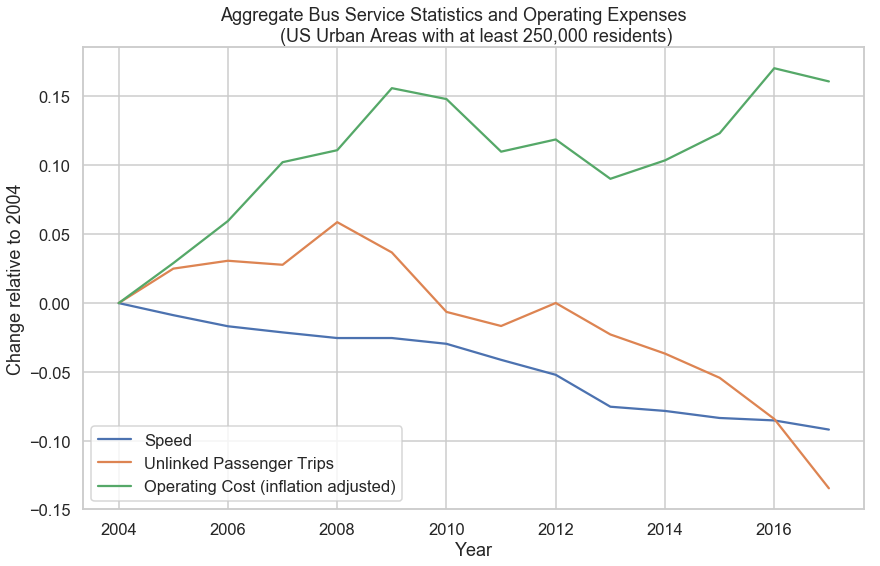

In [257]:
# Chart for aggregate measures (effectively weighted by service, so large agencies have outsize influence)
speed_agg = (((vrm.groupby('Year').sum() / vrh.groupby('Year').sum()) / \
    (vrm.groupby('Year').sum() / vrh.groupby('Year').sum()).loc['2004']) - 1).reset_index('Year')
speed_agg['Year'] = speed_agg['Year'].apply(int)

upt_agg = (upt.groupby('Year').sum() / upt.groupby('Year').sum().loc['2004'] - 1).reset_index('Year')
upt_agg['Year'] = upt_agg['Year'].apply(int)

opex_agg = (opex.groupby('Year').sum() / opex.groupby('Year').sum().loc['2004'] - 1).reset_index('Year')
opex_agg['Year'] = opex_agg['Year'].apply(int)

ax_agg = sns.lineplot(x='Year', y='stat', label='Speed', data=speed_agg)
ax_agg = sns.lineplot(x='Year', y='stat',  label='Unlinked Passenger Trips',data=upt_agg)
ax_agg = sns.lineplot(x='Year', y='stat', label='Operating Cost (inflation adjusted)', data=opex_agg)
ax_agg.set(ylabel='Change relative to 2004', title='Aggregate Bus Service Statistics and Operating Expenses \
       \n (US Urban Areas with at least 250,000 residents)')

ax_agg.legend(loc='lower left')

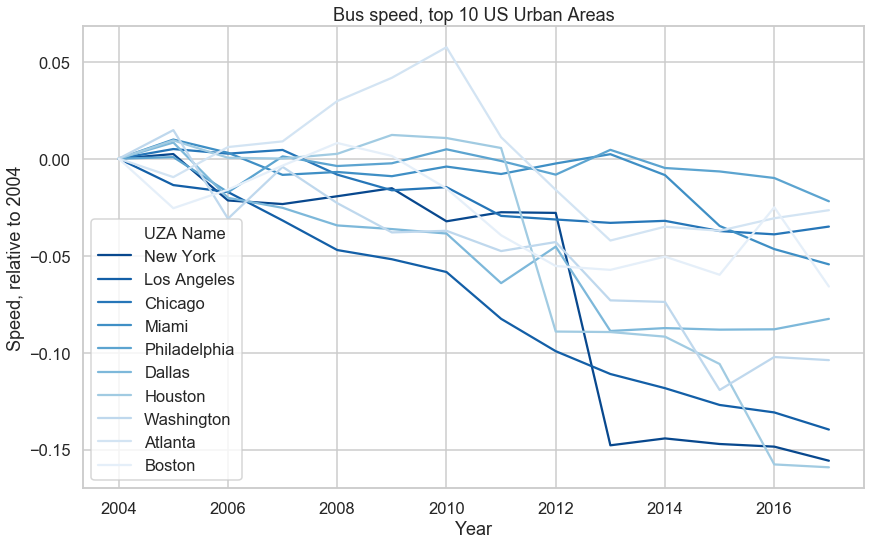

In [258]:
# Plot speed
ax_speed = sns.lineplot(x='Year', y='stat', hue='UZA Name', data=speed.head(140), palette='Blues_r') \
    .set(ylabel='Speed, relative to 2004', title='Bus speed, top 10 US Urban Areas')

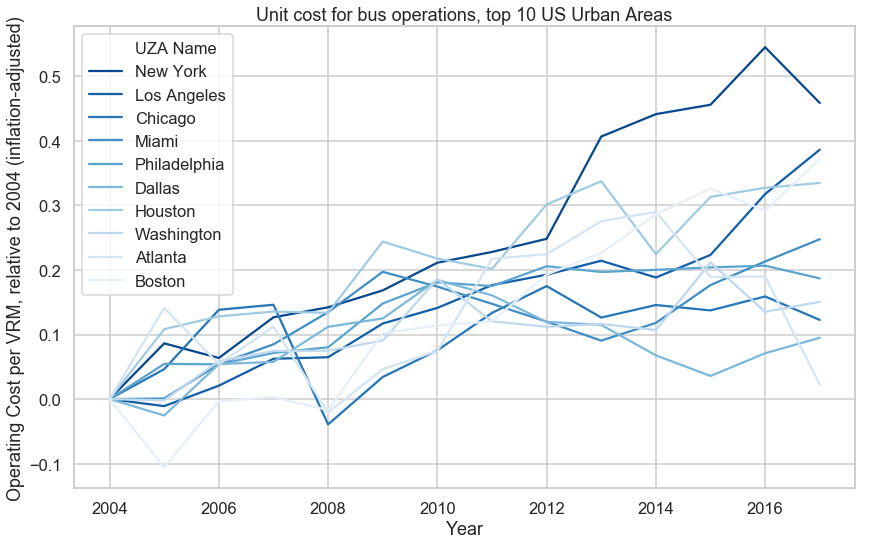

In [259]:
# Plot opex per vrm
ax_opex_vrm = sns.lineplot(x='Year', y='stat', hue='UZA Name', data=opex_vrm.head(140), palette='Blues_r') \
    .set(ylabel='Operating Cost per VRM, relative to 2004 (inflation-adjusted)', title='Unit cost for bus operations, top 10 US Urban Areas')


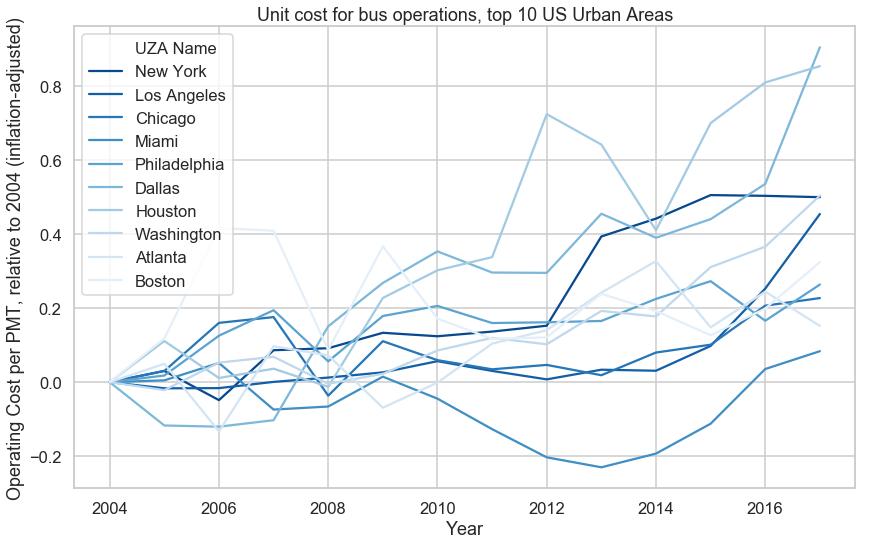

In [260]:
# Plot opex per pmt
ax_opex_pmt = sns.lineplot(x='Year', y='stat', hue='UZA Name', data=opex_pmt.head(140), palette='Blues_r') \
    .set(ylabel='Operating Cost per PMT, relative to 2004 (inflation-adjusted)', title='Unit cost for bus operations, top 10 US Urban Areas')


In [261]:
# Process wage and labor hour data from 2014 and prior years, when these data were in NTD Tables 13 and 18

t13Cols = ["State","Name","ID","Org Type","Mode","TOS","VOMS","Operators Wages","","Other Salaries & Wages","","Fringe Benefits","","Services","","Materials and Supplies Fuel and Lube",""," Tires and Other","","Utilities","","Casuality and Liability","","Purchased Transportation In Report",""," Filing Seperate Report","","Other","","Expense Transfer","","Total",""]
t18Cols = ["State","Name","ID","Org Type","Mode","Employee Type","VOMS","Vehicle Operations","","Vehicle Maintenance","","Non Vehicle Maintenance","","General Admin","","Total Operating"]
colTypes = {2 : str}
years = range(2004,2015)
wages = pd.DataFrame(columns=['Year','Wages'])
hours = pd.DataFrame(columns=['Year','Hours'])

for year in years:
    print('Processing data for %s' % year)
    
    # Wages from NTD Table 13
    # e.g. https://www.transit.dot.gov/ntd/data-product/2007-table-13-transit-operating-expenses-mode-type-service-and-object-class    
    w0 = pd.read_excel(
            'NTD/Wages and Employees/Table 13/%s.xlsx' %year, 
            skiprows = range(0,4), 
            names = t13Cols,
            dtype = colTypes,
        )

    w1 = w0[(w0['Mode'] == 'MB')]  #MB = municipal bus mode TODO: check DO?
    w2 = w1.groupby(['ID']).sum()
    w2['Year'] = year
    w2['Wages'] = (w2['Other Salaries & Wages'] + w2['Operators Wages']) * 1000 * inflation.loc[str(year),'stat']
    wages = wages.append(w2[['Year','Wages']])
    
    # Hours worked from NTD Table 18
    # e.g. https://www.transit.dot.gov/ntd/data-product/2007-table-18-employee-work-hours-and-employee-counts
    
    h0 = pd.read_excel(
            'NTD/Wages and Employees/Table 18/%s.xlsx' %year, 
            skiprows = range(0,5),
            names = t18Cols,
            usecols = range(0,16),
            dtype = colTypes,
        )

    h1 = h0[(h0['Mode'] == 'MB')]  #MB = municipal bus mode TODO: check DO?
    h2 = h1.groupby(['ID']).sum()
    h2['Year'] = year
    h2 = h2.rename(columns={'Total Operating':'Hours'})
    hours = hours.append(h2[['Year','Hours']])
    
# Process wage and labor hour data from "Employees" table, available post 2015 (e.g. 
# https://www.transit.dot.gov/ntd/data-product/2015-employees )
    
yearsEmployeeTableAvailable = range(2015,2018)

for year in yearsEmployeeTableAvailable :
    print('Processing data for %s' % year)
    rawdf = pd.read_excel(
        'NTD/Wages and Employees/Unified Tables/%s Employees.xlsm' % year, 
        'All Employees by Mode',
        converters={
            'Legacy NTD ID': str
        }
    )
    
    emp0 = (rawdf[
        (rawdf['Mode'] == 'MB') &  #MB = municipal bus mode TODO: check DO?
        (rawdf['Reporter Type'] == 'Full Reporter')
    ])
    
    w0 = emp0.groupby(['Legacy NTD ID'])[['Total Operating Salary Expenses']].sum()
    w0['Year'] = year
    w0 = w0.rename(columns={'Total Operating Salary Expenses':'Wages'})
    w0 = w0.rename_axis(index={'Legacy NTD ID':'ID'})
    w0['Wages'] = w0['Wages'] * inflation.loc[str(year),'stat']
    wages = wages.append(w0[['Year','Wages']])
    
    h0 = emp0.groupby(['Legacy NTD ID'])[['Capital Labor Hours','Total Hours']].sum()
    h0['Hours'] = h0['Total Hours']-h0['Capital Labor Hours']
    h0['Year'] = year
    h0 = h0.rename_axis(index={'Legacy NTD ID':'ID'})
    hours = hours.append(h0[['Year','Hours']])


Processing data for 2004
Processing data for 2005
Processing data for 2006
Processing data for 2007
Processing data for 2008
Processing data for 2009
Processing data for 2010
Processing data for 2011
Processing data for 2012
Processing data for 2013
Processing data for 2014
Processing data for 2015
Processing data for 2016
Processing data for 2017
